# Importing Packages

In [41]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
import imageio

In [42]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from customMetrics import dice_loss, dice_coef, iou

In [43]:
from sklearn.metrics import confusion_matrix

In [44]:
from patchify import patchify, unpatchify

In [45]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Loading Utils Functions

In [46]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [47]:
def read_image(path):
    src = cv2.imread(path, cv2.IMREAD_COLOR)
    rgb = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    x = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    
    top, bottom = [28] * 2
    left, right = [37,38]
    
    x = cv2.copyMakeBorder(x, top, bottom, left, right, cv2.BORDER_CONSTANT, value= 0)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

In [48]:
def read_gt(path):
    x = imageio.mimread(path)[0]  ## (128, 128)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)
    return ori_x, x

In [49]:
def load_data(path):
    x = sorted(glob(os.path.join(path, "images", "*.tif")))
    y = sorted(glob(os.path.join(path, "1st_manual", "*.gif")))
    return x, y

In [50]:
def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255

    cat_images = np.concatenate([ori_y, line, y_pred], axis=1)
    
    cv2.imwrite(save_image_path, cat_images)

In [51]:
def save_tests(y_pred, save_image_path):

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255


    cv2.imwrite(save_image_path, y_pred)

In [52]:
def get_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    sen = tp/(tp+fn)
    spe = tn/(tn+fp) 
    return sen, spe

# Setting The Environment

In [53]:
H = 584
W = 565

In [54]:
data_path = "D:\\Data sets\\DRIVE"

In [55]:
""" Save the results in this folder """
create_dir("results")

In [56]:
""" Load the model """
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model = tf.keras.models.load_model("modelDir/model128_basic.h5")


In [57]:
""" Load the dataset """
traindataset_path = os.path.join(data_path,"training")
train_x, train_y = load_data(traindataset_path)

testdataset_path = os.path.join(data_path,"test")
test_x, test_y = load_data(testdataset_path)

In [58]:
testdataset_path,len(test_x)

('D:\\Data sets\\DRIVE\\test', 20)

In [59]:
traindataset_path,len(train_x)

('D:\\Data sets\\DRIVE\\training', 20)

In [60]:
from matplotlib import pyplot as plt

# Training Results

In [76]:
""" Make the prediction and calculate the metrics values """
SCORE = []

for x, y in tqdm(zip(train_x, train_y), total=len(train_x)):
    
    """ Extracting name """
    name = x.split("\\")[-1].split(".")[0]
    print(name)
    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_gt(y)
    
    print(ori_x.shape, ori_y.shape)
    
    patches_img = patchify(x, (128, 128,3), step=128)
    
    pred_patches = []
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):        
            single_patch_img = patches_img[i,j,:,:][0]
#             print(single_patch_img.shape)
            
            """ Prediction """
            y_pred = model.predict(np.expand_dims(single_patch_img, axis=0))[0]
            y_pred = y_pred > 0.5
            y_pred = y_pred.astype(np.int32)
            y_pred = np.squeeze(y_pred, axis=-1)
            
            pred_patches.append(y_pred)
    pred_patches_reshaped = np.reshape(pred_patches, (5, 5, 128,128) )
    reconstructed_image = unpatchify(pred_patches_reshaped, (640,640))
    
    final_y_pred = reconstructed_image[28:-28,37:-38]
    print(final_y_pred.shape)
#     plt.imshow(final_y_pred, cmap='gray')
    
    
    """ Saving the images """
    save_image_path = f"results\\{name}Train.png"
    print(save_image_path)

    save_results(ori_x, ori_y, final_y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    final_y_pred = final_y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, final_y_pred)
    f1_value = f1_score(y, final_y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, final_y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, final_y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, final_y_pred, labels=[0, 1], average="binary")
    
    cm = confusion_matrix(y, final_y_pred)
    sensitivity, specificity = get_metrics(cm)
    
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, sensitivity, specificity])

  0%|                                                                                                                                                         | 0/20 [00:00<?, ?it/s]

21_training
(640, 640, 3) (584, 565)
(584, 565)
results\21_trainingTrain.png


  5%|███████▎                                                                                                                                         | 1/20 [00:02<00:43,  2.29s/it]

22_training
(640, 640, 3) (584, 565)
(584, 565)
results\22_trainingTrain.png


 10%|██████████████▌                                                                                                                                  | 2/20 [00:04<00:39,  2.18s/it]

23_training
(640, 640, 3) (584, 565)
(584, 565)
results\23_trainingTrain.png


 15%|█████████████████████▊                                                                                                                           | 3/20 [00:06<00:36,  2.15s/it]

24_training
(640, 640, 3) (584, 565)
(584, 565)
results\24_trainingTrain.png


 20%|█████████████████████████████                                                                                                                    | 4/20 [00:08<00:35,  2.21s/it]

25_training
(640, 640, 3) (584, 565)
(584, 565)
results\25_trainingTrain.png


 25%|████████████████████████████████████▎                                                                                                            | 5/20 [00:11<00:37,  2.50s/it]

26_training
(640, 640, 3) (584, 565)
(584, 565)
results\26_trainingTrain.png


 30%|███████████████████████████████████████████▌                                                                                                     | 6/20 [00:14<00:34,  2.46s/it]

27_training
(640, 640, 3) (584, 565)
(584, 565)
results\27_trainingTrain.png


 35%|██████████████████████████████████████████████████▊                                                                                              | 7/20 [00:17<00:33,  2.60s/it]

28_training
(640, 640, 3) (584, 565)
(584, 565)
results\28_trainingTrain.png


 40%|██████████████████████████████████████████████████████████                                                                                       | 8/20 [00:19<00:30,  2.52s/it]

29_training
(640, 640, 3) (584, 565)
(584, 565)
results\29_trainingTrain.png


 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 9/20 [00:21<00:27,  2.48s/it]

30_training
(640, 640, 3) (584, 565)
(584, 565)
results\30_trainingTrain.png


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 10/20 [00:24<00:24,  2.45s/it]

31_training
(640, 640, 3) (584, 565)
(584, 565)
results\31_trainingTrain.png


 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 11/20 [00:26<00:21,  2.43s/it]

32_training
(640, 640, 3) (584, 565)
(584, 565)
results\32_trainingTrain.png


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12/20 [00:28<00:19,  2.40s/it]

33_training
(640, 640, 3) (584, 565)
(584, 565)
results\33_trainingTrain.png


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13/20 [00:31<00:17,  2.44s/it]

34_training
(640, 640, 3) (584, 565)
(584, 565)
results\34_trainingTrain.png


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14/20 [00:33<00:14,  2.42s/it]

35_training
(640, 640, 3) (584, 565)
(584, 565)
results\35_trainingTrain.png


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15/20 [00:36<00:11,  2.39s/it]

36_training
(640, 640, 3) (584, 565)
(584, 565)
results\36_trainingTrain.png


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16/20 [00:38<00:09,  2.39s/it]

37_training
(640, 640, 3) (584, 565)
(584, 565)
results\37_trainingTrain.png


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 17/20 [00:40<00:07,  2.38s/it]

38_training
(640, 640, 3) (584, 565)
(584, 565)
results\38_trainingTrain.png


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 18/20 [00:43<00:04,  2.41s/it]

39_training
(640, 640, 3) (584, 565)
(584, 565)
results\39_trainingTrain.png


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 19/20 [00:45<00:02,  2.39s/it]

40_training
(640, 640, 3) (584, 565)
(584, 565)
results\40_trainingTrain.png


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:47<00:00,  2.40s/it]


In [62]:
SCORE

[['21_training',
  0.9684173839253243,
  0.7779127506766405,
  0.6365443638392857,
  0.7401654635412442,
  0.8197170446889738,
  0.7401654635412442,
  0.9868523625786926],
 ['22_training',
  0.9739998787731846,
  0.8479035546494105,
  0.7359657761910624,
  0.8022073870307626,
  0.8991201684463829,
  0.8022073870307626,
  0.9910611658798405],
 ['23_training',
  0.9747575463692569,
  0.8065857000208996,
  0.6758639476961394,
  0.7994752106062698,
  0.8138238050609184,
  0.7994752106062698,
  0.9871105675178515],
 ['24_training',
  0.964262334828464,
  0.8281350201130997,
  0.7066812596388239,
  0.7431531036647572,
  0.9350623704045025,
  0.7431531036647572,
  0.9932369203135766],
 ['25_training',
  0.9482209964844224,
  0.6548415119497364,
  0.4868136489246666,
  0.5117622911995958,
  0.9089736399326978,
  0.5117622911995958,
  0.9945590044620857],
 ['26_training',
  0.9662292399078676,
  0.7687838482767207,
  0.6244101388701632,
  0.6718528995756718,
  0.8983996120271581,
  0.6718528995

In [63]:

stat_df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Sensitivity", "Specificity"])
stat_df

,Image,Acc,F1,Jaccard,Recall,Precision,Sensitivity,Specificity
0,21_training,0.968417,0.777913,0.636544,0.740165,0.819717,0.740165,0.986852
1,22_training,0.974000,0.847904,0.735966,0.802207,0.899120,0.802207,0.991061
2,23_training,0.974758,0.806586,0.675864,0.799475,0.813824,0.799475,0.987111
3,24_training,0.964262,0.828135,0.706681,0.743153,0.935062,0.743153,0.993237
4,25_training,0.948221,0.654842,0.486814,0.511762,0.908974,0.511762,0.994559
5,26_training,0.966229,0.768784,0.624410,0.671853,0.898400,0.671853,0.993072
6,27_training,0.970424,0.819921,0.694802,0.764180,0.884435,0.764180,0.990352
7,28_training,0.969793,0.834597,0.716145,0.780253,0.897078,0.780253,0.990310
8,29_training,0.960250,0.743578,0.591821,0.685273,0.812727,0.685273,0.985500
9,30_training,0.965114,0.734274,0.580120,0.614434,0.912188,0.614434,0.994965


In [64]:
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")
print(f"Sensitivity: {score[5]:0.5f}")
print(f"Specificity: {score[6]:0.5f}")


Accuracy: 0.96962
F1: 0.80839
Jaccard: 0.68176
Recall: 0.76062
Precision: 0.87097
Sensitivity: 0.76062
Specificity: 0.98935


In [65]:
rows = ["Accuracy", "F1", "Jaccard", "Recall", "Precision", "Sensitivity", "Specificity"]

In [66]:
df = pd.DataFrame(
    {'Metrics': rows,
     'Model_128_basic': score,
    })
df

,Metrics,Model_128_vanilla
0,Accuracy,0.969623
1,F1,0.808391
2,Jaccard,0.681758
3,Recall,0.760621
4,Precision,0.870973
5,Sensitivity,0.760621
6,Specificity,0.989346


In [67]:
""" Saving """
df.to_csv("score/train.csv", index=False)

In [68]:
import seaborn as sns

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

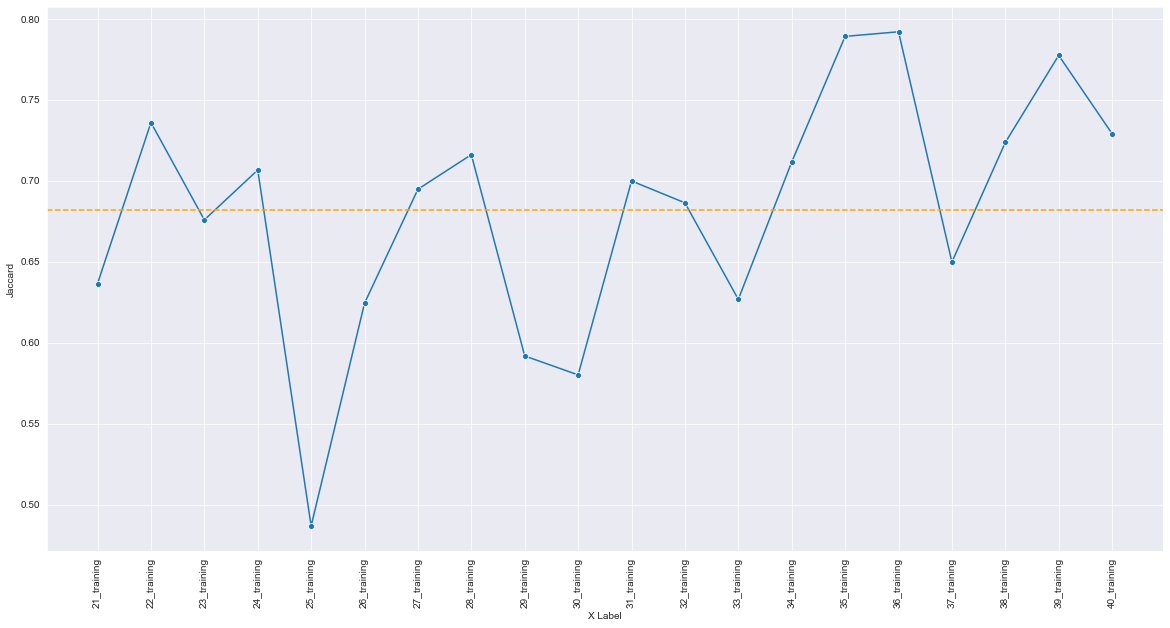

In [69]:
plt.figure(figsize=(20, 10))
sns.set_style("darkgrid")
ax = sns.lineplot(data=stat_df, x="Image", y="F1", marker = "o")
ax.axhline(stat_df["F1"].mean(), color="orange", linestyle="--")
ax.set(xlabel="X Label", ylabel = "F1")
plt.setp(ax.get_xticklabels(), rotation=90)


# Test Results

In [70]:
""" Make the prediction and calculate the metrics values """
SCORE = []

for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    
    """ Extracting name """
    name = x.split("\\")[-1].split(".")[0]
    print(name)
    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_gt(y)
    
    print(ori_x.shape, ori_y.shape)
    
    patches_img = patchify(x, (128, 128,3), step=128)
    
    pred_patches = []
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):        
            single_patch_img = patches_img[i,j,:,:][0]
#             print(single_patch_img.shape)
            
            """ Prediction """
            y_pred = model.predict(np.expand_dims(single_patch_img, axis=0))[0]
            y_pred = y_pred > 0.5
            y_pred = y_pred.astype(np.int32)
            y_pred = np.squeeze(y_pred, axis=-1)
            
            pred_patches.append(y_pred)
    pred_patches_reshaped = np.reshape(pred_patches, (5, 5, 128,128) )
    reconstructed_image = unpatchify(pred_patches_reshaped, (640,640))
    
    final_y_pred = reconstructed_image[28:-28,37:-38]
    print(final_y_pred.shape)
#     plt.imshow(final_y_pred, cmap='gray')
    
    
    """ Saving the images """
    save_image_path = f"results\\{name}Test.png"
    print(save_image_path)

    save_results(ori_x, ori_y, final_y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    final_y_pred = final_y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, final_y_pred)
    f1_value = f1_score(y, final_y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, final_y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, final_y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, final_y_pred, labels=[0, 1], average="binary")
    
    cm = confusion_matrix(y, final_y_pred)
    sensitivity, specificity = get_metrics(cm)
    
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, sensitivity, specificity])

  0%|                                                                                                                                                         | 0/20 [00:00<?, ?it/s]

01_test
(640, 640, 3) (584, 565)
(584, 565)
results\01_testTest.png


  5%|███████▎                                                                                                                                         | 1/20 [00:02<00:46,  2.45s/it]

02_test
(640, 640, 3) (584, 565)
(584, 565)
results\02_testTest.png


 10%|██████████████▌                                                                                                                                  | 2/20 [00:04<00:43,  2.39s/it]

03_test
(640, 640, 3) (584, 565)
(584, 565)
results\03_testTest.png


 15%|█████████████████████▊                                                                                                                           | 3/20 [00:07<00:39,  2.34s/it]

04_test
(640, 640, 3) (584, 565)
(584, 565)
results\04_testTest.png


 20%|█████████████████████████████                                                                                                                    | 4/20 [00:09<00:38,  2.38s/it]

05_test
(640, 640, 3) (584, 565)
(584, 565)
results\05_testTest.png


 25%|████████████████████████████████████▎                                                                                                            | 5/20 [00:12<00:36,  2.45s/it]

06_test
(640, 640, 3) (584, 565)
(584, 565)
results\06_testTest.png


 30%|███████████████████████████████████████████▌                                                                                                     | 6/20 [00:14<00:34,  2.44s/it]

07_test
(640, 640, 3) (584, 565)
(584, 565)
results\07_testTest.png


 35%|██████████████████████████████████████████████████▊                                                                                              | 7/20 [00:16<00:31,  2.39s/it]

08_test
(640, 640, 3) (584, 565)
(584, 565)
results\08_testTest.png


 40%|██████████████████████████████████████████████████████████                                                                                       | 8/20 [00:19<00:28,  2.34s/it]

09_test
(640, 640, 3) (584, 565)
(584, 565)
results\09_testTest.png


 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 9/20 [00:21<00:25,  2.31s/it]

10_test
(640, 640, 3) (584, 565)
(584, 565)
results\10_testTest.png


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 10/20 [00:23<00:22,  2.30s/it]

11_test
(640, 640, 3) (584, 565)
(584, 565)
results\11_testTest.png


 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 11/20 [00:25<00:20,  2.25s/it]

12_test
(640, 640, 3) (584, 565)
(584, 565)
results\12_testTest.png


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12/20 [00:27<00:17,  2.22s/it]

13_test
(640, 640, 3) (584, 565)
(584, 565)
results\13_testTest.png


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13/20 [00:30<00:15,  2.21s/it]

14_test
(640, 640, 3) (584, 565)
(584, 565)
results\14_testTest.png


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14/20 [00:32<00:13,  2.24s/it]

15_test
(640, 640, 3) (584, 565)
(584, 565)
results\15_testTest.png


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15/20 [00:34<00:11,  2.26s/it]

16_test
(640, 640, 3) (584, 565)
(584, 565)
results\16_testTest.png


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16/20 [00:37<00:09,  2.32s/it]

17_test
(640, 640, 3) (584, 565)
(584, 565)
results\17_testTest.png


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 17/20 [00:39<00:06,  2.33s/it]

18_test
(640, 640, 3) (584, 565)
(584, 565)
results\18_testTest.png


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 18/20 [00:42<00:04,  2.41s/it]

19_test
(640, 640, 3) (584, 565)
(584, 565)
results\19_testTest.png


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 19/20 [00:44<00:02,  2.42s/it]

20_test
(640, 640, 3) (584, 565)
(584, 565)
results\20_testTest.png


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:46<00:00,  2.34s/it]


In [71]:
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")
print(f"Sensitivity: {score[5]:0.5f}")
print(f"Specificity: {score[6]:0.5f}")

Accuracy: 0.96132
F1: 0.75469
Jaccard: 0.60737
Recall: 0.68698
Precision: 0.84580
Sensitivity: 0.68698
Specificity: 0.98789


In [72]:
test_df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Sensitivity", "Specificity"])
test_df

,Image,Acc,F1,Jaccard,Recall,Precision,Sensitivity,Specificity
0,01_test,0.963890,0.793153,0.657211,0.775951,0.811135,0.775951,0.982301
1,02_test,0.961332,0.793667,0.657917,0.726221,0.874924,0.726221,0.988155
2,03_test,0.948482,0.682196,0.517677,0.554677,0.885852,0.554677,0.992086
3,04_test,0.962641,0.777543,0.636050,0.709725,0.859691,0.709725,0.988265
4,05_test,0.957174,0.725670,0.569452,0.604620,0.907326,0.604620,0.993616
5,06_test,0.954964,0.723935,0.567319,0.606676,0.897384,0.606676,0.992520
6,07_test,0.959550,0.753732,0.604791,0.677401,0.849449,0.677401,0.987926
7,08_test,0.955358,0.694373,0.531831,0.589418,0.844802,0.589418,0.989807
8,09_test,0.959368,0.698292,0.536443,0.580195,0.876752,0.580195,0.992807
9,10_test,0.963550,0.759185,0.611844,0.698115,0.831966,0.698115,0.987355


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

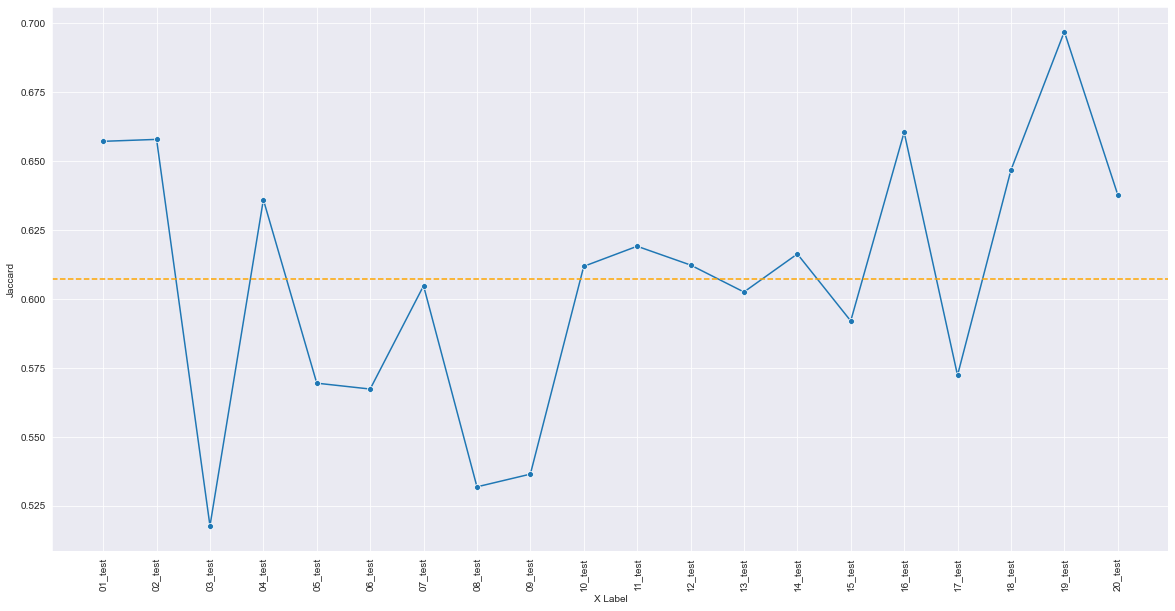

In [73]:
plt.figure(figsize=(20, 10))
sns.set_style("darkgrid")
ax = sns.lineplot(data=test_df, x="Image", y="F1", marker = "o")
ax.axhline(test_df["F1"].mean(), color="orange", linestyle="--")
ax.set(xlabel="X Label", ylabel = "F1")
plt.setp(ax.get_xticklabels(), rotation=90)


In [74]:
df = pd.DataFrame(
    {'Metrics': rows,
     'Model_128_basic': score,
    })
df

,Metrics,Model_128_vanilla
0,Accuracy,0.961324
1,F1,0.754691
2,Jaccard,0.607368
3,Recall,0.686983
4,Precision,0.845800
5,Sensitivity,0.686983
6,Specificity,0.987890


In [75]:
""" Saving """
df.to_csv("score/test.csv", index=False)